In [1]:
# import 

from collections import defaultdict, OrderedDict, Counter
from datetime import datetime

from dateutil.relativedelta import relativedelta
import glob
from itertools import product, combinations
import matplotlib.pyplot as plt
import numpy    as np
#import networkx as nx
from operator import itemgetter
import pandas   as pd
import rdflib as rdflib
import re
from scipy.signal import convolve2d
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer, minmax_scale
from SPARQLWrapper import SPARQLWrapper, JSON, POST
import sys
from rdflib.namespace import XSD, Namespace
from rdflib.term import URIRef

import IPython
import pprint
pp = pprint.PrettyPrinter(indent=4)



from constants import *
from helpers import *

# colors
import matplotlib.colors as mcolors
from matplotlib import cm
# set style
import seaborn as sns

#set_theme() 
sns.set_theme(style="white",palette="PuOr_r")

In [2]:

end_year=2020
start_year=1971
period_length=5
year_range = end_year - start_year
modulo = year_range % period_length
if modulo == 0:
    final_start = end_year - period_length
else:
    final_start = end_year - modulo
final_end = end_year + 1

starts = np.arange(start_year, final_start, period_length).tolist()
tuples = [(start, start+period_length) for start in starts]
# We'll add the last period calculated earlier
tuples.append(tuple([final_start, final_end]))
bins = pd.IntervalIndex.from_tuples(tuples, closed='left')

# helper functions

def to_df(reslist, sort_column):
    my_df=pd.DataFrame(reslist).sort_values(by=sort_column)
    if "year" in my_df.columns:
        my_df["year"]=pd.to_numeric(my_df["year"])
    return my_df


# add period function
def add_period(df_fo, columnname="year"):
    df_fo['period'] = pd.cut(df_fo[columnname], bins=bins, include_lowest=True, precision=0)
    df_fo['period'] = df_fo['period'].astype("str")

    df_fo["period"]=df_fo["period"].apply(lambda x: int(x.split(",")[0].replace("[","")))
    return df_fo

# decade function
def add_decade(df_fi, columname="year"):
    df_fi["decade"]=(df_fi["year"]-1)- ((df_fi["year"]-1)%10)
    
    return df_fi

In [3]:
# data
df_fi=pd.read_csv("../../data/df_fi_all.csv", sep="\t", index_col=0)
df_fo=pd.read_csv("../../data/df_fo_all2.csv", sep="\t", index_col=0)

# graphs

from rdflib import Graph

f = Graph() 

f.parse('../../data/finnish_graph2.nt')

<Graph identifier=Ned89428287154d149c82c619b614b491 (<class 'rdflib.graph.Graph'>)>

In [4]:
# foreign
g = Graph() 
g.parse('../../data/nat_lang_graph.nt')

<Graph identifier=N289d3348160b461da7f76ef14ab227f2 (<class 'rdflib.graph.Graph'>)>

In [152]:
# get nationality labels
# query labels
Q ="""
SELECT  DISTINCT  ?nat ?nationality WHERE {

?author kaunokki:kansallisuus ?nat .
VALUES ?nat { <NAT> }

?nat skos:prefLabel ?nationality . FILTER(LANG(?nationality)="fi")


} GROUP BY  ?nat ?nationality
    

"""

#sparql = SPARQLWrapper("http://ldf.fi/kirjasampo/sparql")

nat_labels_fi=pd.DataFrame()
for nat in df_fi["nat"].unique():
    sparql = SPARQLWrapper("http://ldf.fi/booksampo-2022/sparql")
    q=Q.replace("NAT", nat)
    sparql.setQuery(PREFIXES + q)
    sparql.setReturnFormat(JSON)
    sparql.addCustomHttpHeader(*list(AUTHORIZATION_HEADER.items())[0])
    results = sparql.query().convert()
    temp = JSON2Pandas2(results)
    nat_labels_fi=pd.concat([nat_labels_fi, temp])

,nat,nationality
0,http://www.yso.fi/onto/koko/p35259,suomalaiset
0,http://www.yso.fi/onto/koko/p2682,ruotsinsuomalaiset
0,http://www.yso.fi/onto/koko/p745,saksalaiset
0,http://www.yso.fi/onto/koko/p16897,ruotsalaiset
0,http://www.yso.fi/onto/koko/p14667,kiinalaiset
0,http://www.yso.fi/onto/koko/p13034,neuvostoliittolaiset
0,http://www.yso.fi/onto/koko/p3437,ranskalaiset
0,http://www.yso.fi/onto/koko/p34058,karjalaiset
0,http://seco.tkk.fi/saha3/u86d688aa-7a9f-4e6d-9...,vienankarjalaiset
0,http://www.yso.fi/onto/koko/p55493,kosovolaiset


In [6]:
df_fi=df_fi.merge(nat_labels_fi, how="left")

In [7]:
## other nationalities writing in Finnish, comapre two methods

In [8]:
Q ="""
PREFIX foaf: <http://xmlns.com/foaf/0.1/> 
PREFIX kaunokki: <http://www.yso.fi/onto/kaunokki#> 
PREFIX rel: <http://ldf.fi/relse/> 
PREFIX skos: <http://www.w3.org/2004/02/skos/core#> 
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT  DISTINCT ?teos ?author ?vuosi ?kansallisuus ?gender ?n 

{
  ?teos a rel:novel .
  #?teos rel:langOrig ?kieli .
  #FILTER (?kieli !=  <http://lexvo.org/id/iso639-3/fin>  )
  
 
  ?teos rel:pubYear ?vuosi .
  ?teos rel:hasAuthor ?author .
 OPTIONAL { ?author foaf:gender ?gender_ . }
 BIND(COALESCE(?gender_, "unk") AS ?gender)
 ?author rel:authorNationality  ?n.
 
 FILTER(?vuosi > 1970)
 FILTER(?vuosi < 2021)
  
} GROUP BY ?kieli ?vuosi ?author ?kansallisuus ?gender ?n

"""

qresfi = f.query(Q)

In [9]:
reslistfi=[{"vuosi":str(row.asdict()['vuosi'].toPython()),"teos":str(row.asdict()['teos'].toPython()),"author":str(row.asdict()['author'].toPython()), "gender":str(row.asdict()['gender'].toPython().split("#")[-1]), "kieli":"http://lexvo.org/id/iso639-3/fin",  "nat":str(row.asdict()['n'].toPython())}  for row in qresfi]


In [10]:
df2 = pd.DataFrame(reslistfi).sort_values(by="vuosi")
df2["vuosi"] = pd.to_numeric(df2["vuosi"])
print(len(df2), df2.teos.nunique())
df2.head()

14888 14479


,vuosi,teos,author,gender,kieli,nat
8872,1971,http://www.yso.fi/onto/kaunokki#ateos_51738,http://www.yso.fi/onto/kaunokki#person_1231759...,male,http://lexvo.org/id/iso639-3/fin,http://seco.tkk.fi/saha3/u86d688aa-7a9f-4e6d-9...
12937,1971,http://www.yso.fi/onto/kaunokki#ateos_54281,http://www.yso.fi/onto/kaunokki#person_1231759...,male,http://lexvo.org/id/iso639-3/fin,http://www.yso.fi/onto/koko/p35259
10520,1971,http://www.yso.fi/onto/kaunokki#ateos_22207,http://www.yso.fi/onto/kaunokki#person_1231759...,male,http://lexvo.org/id/iso639-3/fin,http://www.yso.fi/onto/koko/p35259
9518,1971,http://www.yso.fi/onto/kaunokki#ateos_27914,http://www.yso.fi/onto/kaunokki#person_1231759...,female,http://lexvo.org/id/iso639-3/fin,http://www.yso.fi/onto/koko/p35259
2893,1971,http://www.yso.fi/onto/kaunokki#ateos_24764,http://www.yso.fi/onto/kaunokki#person_1231759...,male,http://lexvo.org/id/iso639-3/fin,http://www.yso.fi/onto/koko/p35259


In [11]:
df2=df2.merge(nat_labels_fi, how="left")

In [12]:
foreign=df2[df2["nationality"]!="suomalaiset"]
foreign[foreign["vuosi"]>1999].groupby("nationality")["teos"].nunique().sort_values()

nationality
alankomaalaiset        1
intialaiset            1
ranskalaiset           1
unkarilaiset           1
afganistanilaiset      2
australialaiset        2
iranilaiset            2
israelilaiset          2
venäläiset             2
kiinalaiset            2
vienankarjalaiset      2
kosovolaiset           3
somalit                3
norjalaiset            4
saamelaiset            5
saksalaiset            6
kanadalaiset           6
yhdysvaltalaiset      10
ruotsalaiset          12
ruotsinsuomalaiset    49
Name: teos, dtype: int64

In [13]:
# see how many nationalities
foreigns=df2[(df2["vuosi"]>1999) & (~df2["nat"].isin(["http://www.yso.fi/onto/koko/p35259","http://www.yso.fi/onto/koko/p2682"]))]
print(foreigns["author"].nunique())
foreigns.groupby("nat")["author"].nunique()

46


nat
http://seco.tkk.fi/saha3/u5aa143b0-c88f-47a0-8135-4f8530d98b08     1
http://seco.tkk.fi/saha3/u86d688aa-7a9f-4e6d-92b4-6b5508e4ac8e     2
http://www.yso.fi/onto/koko/p11118                                 2
http://www.yso.fi/onto/koko/p14632                                 1
http://www.yso.fi/onto/koko/p14667                                 1
http://www.yso.fi/onto/koko/p16897                                 7
http://www.yso.fi/onto/koko/p2224                                  2
http://www.yso.fi/onto/koko/p3113                                  2
http://www.yso.fi/onto/koko/p32570                                 4
http://www.yso.fi/onto/koko/p3437                                  1
http://www.yso.fi/onto/koko/p34461                                 1
http://www.yso.fi/onto/koko/p52079                                 1
http://www.yso.fi/onto/koko/p5227                                  1
http://www.yso.fi/onto/koko/p53753                                 1
http://www.yso.fi/onto/koko/p5

In [14]:
#other way
# nationalities of authors writing in Finnish
df2_2= df_fi[df_fi["nat"]!="nonat"]

# see how many nationalities
foreigns_2=df2_2[(df2_2["year"]>1999) & (~df2_2["nat"].isin(["http://www.yso.fi/onto/koko/p35259"]))] # kaikki muut paitsi suomalaiset
print(foreigns_2["author"].nunique())
foreigns_2.groupby("nationality")["author"].nunique()

54


nationality
afganistanilaiset      1
alankomaalaiset        1
australialaiset        1
intialaiset            1
iranilaiset            1
israelilaiset          1
kanadalaiset           1
kiinalaiset            1
kosovolaiset           1
norjalaiset            1
ranskalaiset           1
ruotsalaiset           5
ruotsinsuomalaiset    27
saamelaiset            4
saksalaiset            1
somalit                2
unkarilaiset           1
venäläiset             2
vienankarjalaiset      2
yhdysvaltalaiset       2
Name: author, dtype: int64

In [15]:
# novel count
#print(foreigns["lang"].nunique())
print(foreigns_2["nationality"].nunique())
foreigns_workCount=foreigns_2.groupby(["nationality","year"])["novel"].nunique().sort_values().reset_index()
foreigns_workCount.groupby("nationality")["novel"].sum()

20


nationality
afganistanilaiset      2
alankomaalaiset        1
australialaiset        2
intialaiset            1
iranilaiset            2
israelilaiset          2
kanadalaiset           5
kiinalaiset            2
kosovolaiset           3
norjalaiset            3
ranskalaiset           1
ruotsalaiset          12
ruotsinsuomalaiset    49
saamelaiset            5
saksalaiset            3
somalit                3
unkarilaiset           1
venäläiset             2
vienankarjalaiset      2
yhdysvaltalaiset       2
Name: novel, dtype: int64

In [16]:
# add period
df3 = add_period(df2_2)
dfplot=df3.groupby(["period","nationality"])["novel"].nunique().reset_index()

/tmp/ipykernel_7550/642665547.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fo['period'] = pd.cut(df_fo[columnname], bins=bins, include_lowest=True, precision=0)
/tmp/ipykernel_7550/642665547.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fo['period'] = df_fo['period'].astype("str")
/tmp/ipykernel_7550/642665547.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [17]:
# kielet, joita suomalaiset ilmoittavat osaavansa


Q ="""
SELECT  DISTINCT ?author ?lang  WHERE {

?author kaunokki:kansallisuus <http://www.yso.fi/onto/koko/p35259> .

?author kaunokki:aidinkieli ?lang .

OPTIONAL { ?lang skos:prefLabel ?langlabel. FILTER(LANG(?langlabel)="fi") }
} GROUP BY ?author ?lang
    

"""
sparql = SPARQLWrapper("http://ldf.fi/booksampo-2022/sparql")
#sparql = SPARQLWrapper("http://ldf.fi/kirjasampo/sparql")
sparql.setQuery(PREFIXES + Q)
sparql.setReturnFormat(JSON)
sparql.addCustomHttpHeader(*list(AUTHORIZATION_HEADER.items())[0])
results = sparql.query().convert()
temp = JSON2Pandas2(results)

In [18]:
# replace old language codes

temp["lang"]=temp["lang"].replace({"http://www.lingvoj.org/lang/smi": "http://lexvo.org/id/iso639-5/smi" })
temp["lang"]=temp["lang"].replace({"http://www.lingvoj.org/lang/fiu": "http://www.lexvo.org/id/iso639-5/fiu" })

In [19]:
# languages in the Finnish authors' language repertoire:
temp.groupby("lang").count().sort_values(by="author").tail(20)

,author
lang,
http://lexvo.org/id/iso639-3/ell,20
http://lexvo.org/id/iso639-3/lat,23
http://lexvo.org/id/iso639-3/isl,26
http://lexvo.org/id/iso639-3/sme,30
http://lexvo.org/id/iso639-3/pol,31
http://lexvo.org/id/iso639-5/smi,32
http://lexvo.org/id/iso639-3/nld,35
http://lexvo.org/id/iso639-3/jpn,38
http://lexvo.org/id/iso639-3/hun,52


In [20]:
# merge 
temp2=temp[temp["lang"]!="http://lexvo.org/id/iso639-3/fin"]

df4=df3.merge(temp2, on ="author", how="left").sort_values(["year","novel"])
df4

,year,author,nat,gender,novel,publisher,pubName,genre,year_genre,decade,nationality,period,lang
11141,1971,http://seco.tkk.fi/saha3/ud002c846-02a3-42cb-9...,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#male,http://data.kirjasampo.fi/abstractWork_1883820,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Gummerus,NaN,NaN,NaN,suomalaiset,1971,NaN
6017,1971,http://www.seco.tkk.fi/applications/saha#Insta...,http://www.yso.fi/onto/koko/p16897,http://www.yso.fi/onto/kaunokki#female,http://data.kirjasampo.fi/abstractWork_9510039748,NaN,NaN,NaN,NaN,NaN,ruotsalaiset,1971,NaN
95,1971,http://seco.tkk.fi/saha3/uf30383c5-5636-4984-8...,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#female,http://seco.tkk.fi/saha3/u003aee4c-cdde-4b01-8...,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Kauppiaitten kustannus,NaN,NaN,NaN,suomalaiset,1971,NaN
9519,1971,http://seco.tkk.fi/saha3/u3fb85111-146a-42a0-b...,http://www.yso.fi/onto/koko/p35259,unk,http://seco.tkk.fi/saha3/u00d9297f-b302-4226-a...,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Tammi,NaN,NaN,NaN,suomalaiset,1971,NaN
867,1971,http://seco.tkk.fi/saha3/ue9278283-cdac-4a41-b...,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#female,http://seco.tkk.fi/saha3/u03e794f3-e2eb-4a4c-a...,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Tammi,NaN,NaN,NaN,suomalaiset,1971,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1779,2020,http://data.kirjasampo.fi/actor_Vir%C3%A9n%2C+...,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#male,http://seco.tkk.fi/saha3/uc7ded24c-24b8-4e62-9...,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,BoD - Books on Demand,NaN,NaN,NaN,suomalaiset,2016,NaN
3306,2020,http://seco.tkk.fi/saha3/ufa166e46-978a-4e95-9...,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#female,http://seco.tkk.fi/saha3/uf06ad44d-4c88-474b-9...,http://www.yso.fi/onto/kaunokki#Kustantaja_123...,Eget förlag,NaN,NaN,NaN,suomalaiset,2016,NaN
2159,2020,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#male,http://seco.tkk.fi/saha3/uf5589ca5-601c-479c-a...,http://data.kirjasampo.fi/actor_Saga+Egmont%2C...,Saga Egmont,NaN,NaN,NaN,suomalaiset,2016,NaN
6806,2020,http://www.yso.fi/onto/kaunokki#person_1231759...,http://www.yso.fi/onto/koko/p35259,http://www.yso.fi/onto/kaunokki#male,http://www.yso.fi/onto/kaunokki#ateos_31331,http://data.kirjasampo.fi/actor_Kustantamo+Hel...,Helmivyö,NaN,NaN,NaN,suomalaiset,2016,NaN


In [21]:
df4[~df4["lang"].isna()]["author"].nunique()

206

In [22]:
dfplot4=df4.groupby(["period","lang"])["author"].nunique().reset_index() # author or novel!!!???


In [40]:
all_n=list(set(list(dfplot.nationality.unique())))

n_labels=[l for l in all_n]
num_lang=len(n_labels)
print(num_lang)

# color palette
from matplotlib.colors import Normalize

from matplotlib import cm

new_map = cm.gray.from_list('whatever', ('red', "orange","gold","green","lightblue",'blue',"magenta","purple","brown"), N=num_lang+1)
#list(new_map)
cm.register_cmap("mycolormap3", new_map)
cpal2 = sns.color_palette("mycolormap3", n_colors=num_lang)
cmappable2 = cm.ScalarMappable(norm=Normalize(0,1), cmap=new_map)

color_map2={l:c for l,c in zip(n_labels,cpal2)}
print(color_map2.keys())
color_map2["britit"]=sns.color_palette("PuOr")[4]
color_map2["yhdysvaltalaiset"]=sns.color_palette("PuOr",8)[7]
color_map2["kanadalaiset"]=sns.color_palette("PuOr",8)[6]


color_map2["ruotsalaiset"]=sns.color_palette("Blues",8)[5]
#color_map["islantilaiset"]=sns.color_palette("Blues",8)[2]
color_map2["norjalaiset"]=sns.color_palette("Blues",8)[3]
color_map2["tanskalaiset"]=sns.color_palette("Blues",8)[4]
color_map2["kosovolaiset"]=sns.color_palette("PuOr")[3]

color_map2["ranskalaiset"]=sns.color_palette("PuOr")[2]
color_map2["saksalaiset"]=sns.color_palette("PuOr")[1]
color_map2["venäläiset"]=sns.color_palette("PuOr")[0]
color_map2["espanjalaiset"]=sns.color_palette("PuOr", 8)[1]
color_map2["saamelaiset"]=sns.color_palette("Blues",8)[6]
color_map2["suomalaiset"]=sns.color_palette("Blues",8)[7]
color_map2["ruotsinsuom."]=sns.color_palette("Blues",8)[6]
color_map2["karjalaiset"]=sns.color_palette("Greens",8)[7]
color_map2["vienankarjalaiset"]=sns.color_palette("Greens",8)[4]

26
dict_keys(['ranskalaiset', 'alankomaalaiset', 'norjalaiset', 'afganistanilaiset', 'iranilaiset', 'karjalaiset', 'unkarilaiset', 'neuvostoliittolaiset', 'saamelaiset', 'kiinalaiset', 'tamilit', 'saksalaiset', 'kosovolaiset', 'yhdysvaltalaiset', 'ruotsinsuom.', 'kanadalaiset', 'somalit', 'intialaiset', 'ruotsalaiset', 'tanskalaiset', 'australialaiset', 'suomalaiset', 'venäläiset', 'inkeriläiset', 'israelilaiset', 'vienankarjalaiset'])


/tmp/ipykernel_7550/3819997738.py:14: UserWarning: Trying to register the cmap 'mycolormap3' which already exists.
  cm.register_cmap("mycolormap3", new_map)


In [24]:
# color palette
from matplotlib.colors import Normalize

from matplotlib import cm

all_langs=list(set(list(dfplot4.lang.unique()) + list(dfplot4.lang.unique())))

lang_labels=[l for l in all_langs]
num_lang=len(all_langs)
num_lang


new_map = cm.gray.from_list('whatever', ('red', "orange","gold","green","lightblue",'blue',"magenta","purple","brown"), N=num_lang)
#list(new_map)
cm.register_cmap("mycolormap2", new_map)
cpal = sns.color_palette("mycolormap2", n_colors=num_lang)
cmappable = cm.ScalarMappable(norm=Normalize(0,1), cmap=new_map)

color_map={l:c for l,c in zip(lang_labels,cpal)}
color_map["eng"]=sns.color_palette("PuOr")[4]
color_map["swe"]=sns.color_palette("Blues",8)[5]
color_map["nor"]=sns.color_palette("Blues",8)[2]
color_map["nor"]=sns.color_palette("Blues",8)[3]
color_map["dan"]=sns.color_palette("Blues",8)[4]
color_map["fra"]=sns.color_palette("PuOr")[2]
color_map["deu"]=sns.color_palette("PuOr")[1]
color_map["rus"]=sns.color_palette("PuOr")[0]
color_map["spa"]=sns.color_palette("PuOr", 8)[1]
color_map["smi"]=sns.color_palette("Blues",12)[10]
color_map["sme"]=sns.color_palette("Blues",12)[11]

In [25]:
print(dfplot.nationality.nunique())
dfplot["nationality"]=dfplot["nationality"].replace({"ruotsinsuomalaiset": "ruotsinsuom." })

nationalitylabels=list(dfplot[dfplot["nationality"]!="suomalaiset"].sort_values(by="novel", ascending=False).nationality.unique())
nationalitylabels#[0] ="ruotsinsuom."

26


['ruotsinsuom.',
 'vienankarjalaiset',
 'ruotsalaiset',
 'saksalaiset',
 'karjalaiset',
 'saamelaiset',
 'kanadalaiset',
 'yhdysvaltalaiset',
 'iranilaiset',
 'somalit',
 'neuvostoliittolaiset',
 'venäläiset',
 'norjalaiset',
 'kosovolaiset',
 'afganistanilaiset',
 'israelilaiset',
 'ranskalaiset',
 'unkarilaiset',
 'kiinalaiset',
 'intialaiset',
 'alankomaalaiset',
 'tanskalaiset',
 'inkeriläiset',
 'tamilit',
 'australialaiset']

In [26]:
#languagelabels=["englanti","ruotsi","ranska","saksa",""]

In [27]:
dfplot4["lang"]=dfplot4["lang"].apply(lambda x: x.split("/")[-1])

In [29]:
def jitter(values,j):
    
    return values + np.random.normal(j,1,values.shape)

dfplot["jitter"]=jitter(dfplot[dfplot["nationality"]!="suomalaiset"]["period"],0)-1
dfplot4["jitter"]=jitter(dfplot4["period"],0)-1

#dfplot[dfplot["nationality"]!="suomalaiset"]["period"].shape

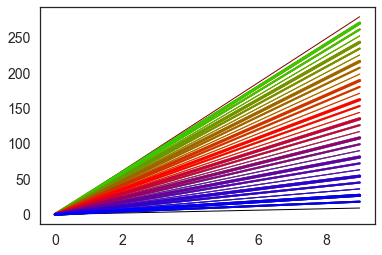

In [43]:
markers=24  *["o","v","s","*"]
NUM_COLORS=30
NUM_COLORS2=40
TOTAL=90
cm = plt.get_cmap('gnuplot2')
cm2=plt.get_cmap('turbo')
cm3=plt.get_cmap('brg')
fig = plt.figure()
ax = fig.add_subplot(111)
colors=[]
for i in range(TOTAL):
    #print(i)
    if i < 31:
        lines = ax.plot(np.arange(10)*(i+1))
        lines[0].set_color(cm(i//3*3.0/NUM_COLORS))
        colors.append(cm(i//3*3.0/NUM_COLORS))
        lines[0].set_linewidth(i%3 + 1)
    elif i>30 and i < 61:
        j=61-i
       # print(j)
        lines = ax.plot(np.arange(10)*(j+1))
        lines[0].set_color(cm2(j//3*3.0/NUM_COLORS))
        colors.append(cm2(j//3*3.0/NUM_COLORS))
        lines[0].set_linewidth(j%3 + 1)
    else:
        j=90-i
        #print(j,i)
       # print(j)
        lines = ax.plot(np.arange(10)*(j+1))
        lines[0].set_color(cm3(j//3*3.0/NUM_COLORS))
        colors.append(cm3(j//3*3.0/NUM_COLORS))
        lines[0].set_linewidth(j%3 + 1)

25


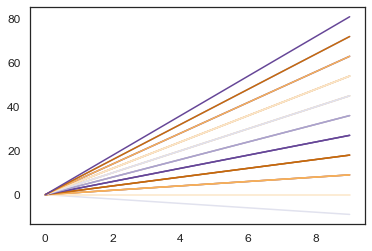

In [146]:
NUM_COLORS=8

TOTAL=25
cm2 = sns.color_palette('tab20b',8)
cm=sns.color_palette('ocean_r',8)
cm3=sns.color_palette('rocket_r',12)
cm4=plt.get_cmap('Set2',8)
fig = plt.figure()
ax = fig.add_subplot(111)
colors=[]
for i in range(TOTAL):
    #print(i)
    if i < 8:
        lines = ax.plot(np.arange(10)*(i+1))
        #lines[0].set_color(cm(i//3*3.0/NUM_COLORS))
        colors.append(cm[i])
        #lines[0].set_linewidth(i%3 + 1)
    elif i>7 and i < 16:
        j=i-10
       # print(j)
        lines = ax.plot(np.arange(10)*(j+1))
        colors.append(cm2[j])
        #lines[0].set_color(cm2(j//3*3.0/NUM_COLORS))
        #colors.append(cm2(j//3*3.0/NUM_COLORS))
        #lines[0].set_linewidth(j%3 + 1)
    else:
        j=i-16
        #print(j,i)
       # print(j)
        colors.append(cm3[j])
        lines = ax.plot(np.arange(10)*(j+1))
        #lines[0].set_color(cm3(j//3*3.0/NUM_COLORS))
        #colors.append(cm3(j//3*3.0/NUM_COLORS))
        #lines[0].set_linewidth(j%3 + 1)
print(len(colors))
colormap_newer={nat:c for nat,c in zip(newdfplot["nationality"].unique(), colors)}


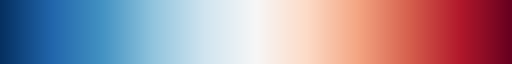

In [106]:
cm

In [107]:
#dfplot["markers"]=markers
colormap_new={nat:c for nat,c in zip(dfplot.sort_values(by="nationality")["nationality"], colors)}
mdict= {nat:m for  nat,m in zip(dfplot.sort_values(by="nationality")["nationality"], markers)}
#colormap_new
#dfplot

{'afganistanilaiset': (0.0196078431372549,
  0.18823529411764706,
  0.3803921568627451,
  1.0),
 'alankomaalaiset': (0.0196078431372549,
  0.18823529411764706,
  0.3803921568627451,
  1.0),
 'australialaiset': (0.7614763552479817,
  0.8685121107266438,
  0.924567474048443,
  1.0),
 'inkeriläiset': (0.7614763552479817,
  0.8685121107266438,
  0.924567474048443,
  1.0),
 'intialaiset': (0.8945790080738177,
  0.5038062283737024,
  0.39976931949250283,
  1.0),
 'iranilaiset': (0.8945790080738177,
  0.5038062283737024,
  0.39976931949250283,
  1.0),
 'israelilaiset': (0.03137254901960784,
  0.11372549019607843,
  0.34509803921568627,
  1.0),
 'kanadalaiset': (0.11538638985005767,
  0.5703344867358708,
  0.7531257208765859,
  1.0),
 'karjalaiset': (0.7838985005767013,
  0.9151095732410611,
  0.7056055363321799,
  1.0),
 'kiinalaiset': (0.4, 0.7607843137254902, 0.6470588235294118, 1.0),
 'kosovolaiset': (0.4, 0.7607843137254902, 0.6470588235294118, 1.0),
 'neuvostoliittolaiset': (0.9058823529

In [87]:
my_order=dfplot.groupby("nationality")["period"].min().sort_values().index
print(len(my_order), len(colormap_newer))

26 15


In [83]:
newdfplot=pd.DataFrame()

for n in my_order:
    temp=dfplot[dfplot["nationality"]==n]
    newdfplot=pd.concat([newdfplot, temp])
    
newdfplot=newdfplot[newdfplot["nationality"]!="suomalaiset"]
newdfplot.nationality.nunique()

25

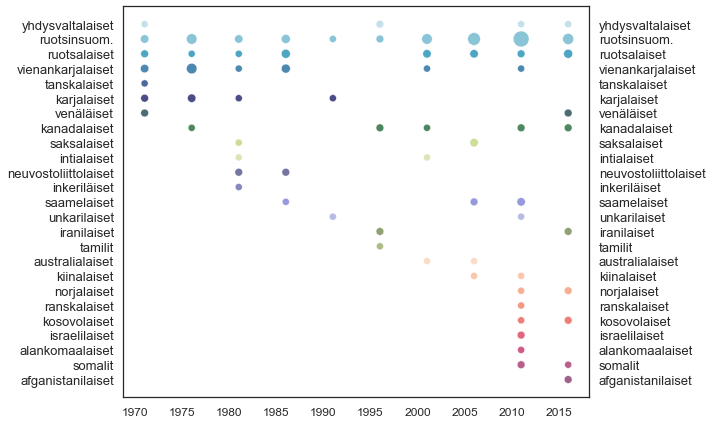

In [171]:
fig, ax= plt.subplots(1,1,figsize=(10,6))


plt.rcParams["ytick.labelsize"] = 13
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["axes.labelsize"]=12

x= df3["period"].unique()


# suomeksi kirjoittavien kansalaisuudet 

ax=sns.scatterplot(y="nationality",x="period",#hue="lang", 
                      #jitter=True,
                      data=newdfplot, hue="nationality",
                      size="novel",sizes=(50, 250),alpha=0.7, 
                  # style=markers[:86],
                   ax=ax,
                     palette=colormap_newer,
                     )




#,  color=sns.color_palette("prism"))
#ax[1]=sns.scatterplot(y=y2_fi,x=x,marker="o", ax=ax[1], label="authors_fi", color=sns.color_palette("Blues")[4])
#ax[1]=sns.scatterplot(y=y1_fi,x=x, ax=ax[1], marker="*",s=70, label="novels_fi", color=sns.color_palette("Blues")[5])

ax.set(xlabel='', ylabel='')
#ax[1].set(xlabel='', ylabel='')
#ax[2].set(xlabel='', ylabel='')

#ax.set_title('Suomeksi kirjoittavien muut kansalaisuudet', fontsize=14)
#ax[1].set_title('Suomen kansalaisten muunkieliset kirjat', fontsize=18)
#ax[1].set_title('Suomeksi kirjoittavien ilmoittama kielitaito', fontsize=18)

#ax.legend([],[], frameon=False)
#ax[1].legend([],[], frameon=False)
#ax[1].legend([],[], frameon=False)
start=1970
end=2020
starty=0
endy=21
ax.xaxis.set_ticks(np.arange(start, end, 5))
#ax.yaxis.set_ticks(np.arange(starty, endy, 5))
#ax[1].xaxis.set_ticks(np.arange(start, end, 5))
#ax[1].xaxis.set_ticks(np.arange(start, end, 5))
#ax.set_yticklabels(labels=nationalitylabels#,rotation=20, ha='right', 
#                      )
#ax[1].yaxis.

#plt.rcParams['axes.titlesize'] = 16
#ax.yaxis.tick_right()
ax.tick_params(axis='y', which='both', labelleft=True, labelright=True)
ax.legend("",frameon=False)
#lgd=ax.legend(loc='center', bbox_to_anchor=(0.5, 
#                                               -0.25),
#          ncol=6, fancybox=False, shadow=False,prop={'size': 12}) 
fig.tight_layout()
fig.savefig("../../output/suomeksi_kansalaisuudet.png")

In [175]:
newdfplot.head(20)

,period,nationality,novel,jitter
7,1971,yhdysvaltalaiset,1,1968.965381
38,1996,yhdysvaltalaiset,2,1993.883954
67,2011,yhdysvaltalaiset,1,2009.823542
78,2016,yhdysvaltalaiset,1,2015.660201
2,1971,ruotsinsuom.,3,1969.963934
11,1976,ruotsinsuom.,7,1975.178377
19,1981,ruotsinsuom.,3,1981.874634
25,1986,ruotsinsuom.,4,1983.758709
30,1991,ruotsinsuom.,1,1989.986115
35,1996,ruotsinsuom.,2,1996.754603


In [166]:
# verify some novels


nat_labels_fi[nat_labels_fi["nationality"]=="neuvostoliittolaiset"]

,nat,nationality
0,http://www.yso.fi/onto/koko/p13034,neuvostoliittolaiset


In [167]:
# kielet, joita suomalaiset ilmoittavat osaavansa


Q ="""
SELECT  DISTINCT ?author ?nimi ?kirja  WHERE {

?teos kaunokki:tekija ?author .
?author kaunokki:kansallisuus <http://www.yso.fi/onto/koko/p13034> .
?author skos:prefLabel ?nimi .
?teos a kaunokki:romaani . ?teos skos:prefLabel ?kirja .
?teos kaunokki:alkukieli <http://lexvo.org/id/iso639-3/fin>  . #suomeksi

FILTER(LANG(?kirja)="fi") 
} 
    

"""
sparql = SPARQLWrapper("http://ldf.fi/booksampo-2022/sparql")
#sparql = SPARQLWrapper("http://ldf.fi/kirjasampo/sparql")
sparql.setQuery(PREFIXES + Q)
sparql.setReturnFormat(JSON)
sparql.addCustomHttpHeader(*list(AUTHORIZATION_HEADER.items())[0])
results = sparql.query().convert()
checkdf = JSON2Pandas2(results)

checkdf

,author,nimi,kirja
0,http://www.yso.fi/onto/kaunokki#person_1231759...,"Huuskonen, Taisto",Maa kaipaa isäntää
1,http://www.yso.fi/onto/kaunokki#person_1231759...,"Huuskonen, Taisto",Jermut
2,http://www.yso.fi/onto/kaunokki#person_1231759...,"Huuskonen, Taisto",Jermut jatkosodassa
3,http://www.yso.fi/onto/kaunokki#person_1231759...,"Huuskonen, Taisto",Juttuja ja kertomuksia eri vuosilta
4,http://www.yso.fi/onto/kaunokki#person_1231759...,"Huuskonen, Taisto",Huomenen oraat
5,http://www.yso.fi/onto/kaunokki#person_1231759...,"Huuskonen, Taisto",Teräsmyrsky
6,http://www.yso.fi/onto/kaunokki#person_1231759...,"Huuskonen, Taisto",Moukarin kaiku
7,http://www.yso.fi/onto/kaunokki#person_1231759...,"Huuskonen, Taisto",Teräsmyrsky Kannaksella


### not necessary stuff

ValueError: The palette dictionary is missing keys: {'tanskalaiset', 'venäläiset', 'tamilit', 'ruotsinsuom.', 'saksalaiset', 'yhdysvaltalaiset', 'unkarilaiset', 'vienankarjalaiset', 'somalit', 'saamelaiset'}

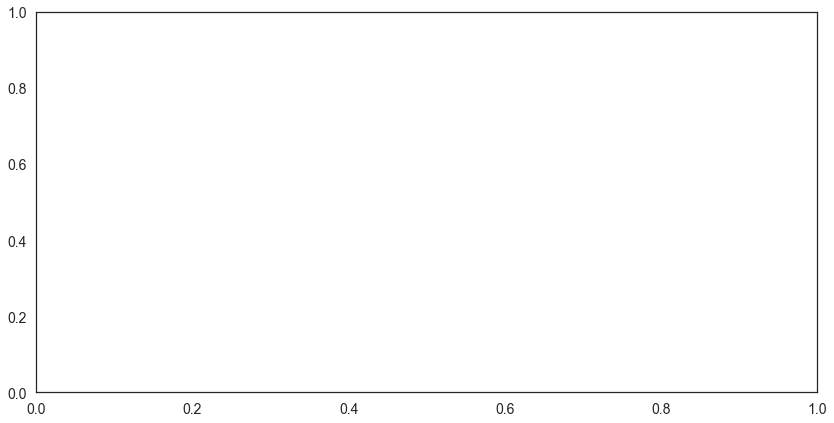

In [85]:
fig, ax= plt.subplots(1,1,figsize=(14,7))


plt.rcParams["ytick.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["axes.labelsize"]=12

x= df3["period"].unique()


# suomeksi kirjoittavien kansalaisuudet 

ax=sns.scatterplot(y="novel",x="jitter",#hue="lang", 
                      #jitter=True,
                      data=dfplot[dfplot["nationality"]!="suomalaiset"].sort_values(by="nationality"), hue="nationality",
                      size="novel",sizes=(100, 250),alpha=0.7, 
                  # style=markers[:86],
                   ax=ax,
                     palette=colormap_new
                     )




#,  color=sns.color_palette("prism"))
#ax[1]=sns.scatterplot(y=y2_fi,x=x,marker="o", ax=ax[1], label="authors_fi", color=sns.color_palette("Blues")[4])
#ax[1]=sns.scatterplot(y=y1_fi,x=x, ax=ax[1], marker="*",s=70, label="novels_fi", color=sns.color_palette("Blues")[5])

ax.set(xlabel='', ylabel='')
#ax[1].set(xlabel='', ylabel='')
#ax[2].set(xlabel='', ylabel='')

ax.set_title('Suomeksi kirjoittavien muut kansalaisuudet', fontsize=14)
#ax[1].set_title('Suomen kansalaisten muunkieliset kirjat', fontsize=18)
#ax[1].set_title('Suomeksi kirjoittavien ilmoittama kielitaito', fontsize=18)

#ax.legend([],[], frameon=False)
#ax[1].legend([],[], frameon=False)
#ax[1].legend([],[], frameon=False)
start=1970
end=2020
starty=0
endy=21
ax.xaxis.set_ticks(np.arange(start, end, 5))
ax.yaxis.set_ticks(np.arange(starty, endy, 5))
#ax[1].xaxis.set_ticks(np.arange(start, end, 5))
#ax[1].xaxis.set_ticks(np.arange(start, end, 5))
#ax.set_yticklabels(labels=nationalitylabels#,rotation=20, ha='right', 
#                      )
#ax[1].yaxis.

#plt.rcParams['axes.titlesize'] = 16

lgd=ax.legend(loc='center', bbox_to_anchor=(0.5, 
                                               -0.25),
          ncol=6, fancybox=False, shadow=False,prop={'size': 12}) 
fig.tight_layout()

In [51]:
dfplot

,period,nationality,novel,jitter
0,1971,karjalaiset,2,1971.798613
1,1971,ruotsalaiset,2,1970.486866
2,1971,ruotsinsuom.,3,1969.963934
3,1971,suomalaiset,702,NaN
4,1971,tanskalaiset,1,1971.387154
...,...,...,...,...
74,2016,ruotsinsuom.,8,2012.666497
75,2016,somalit,1,2013.119409
76,2016,suomalaiset,3874,NaN
77,2016,venäläiset,2,2015.249689


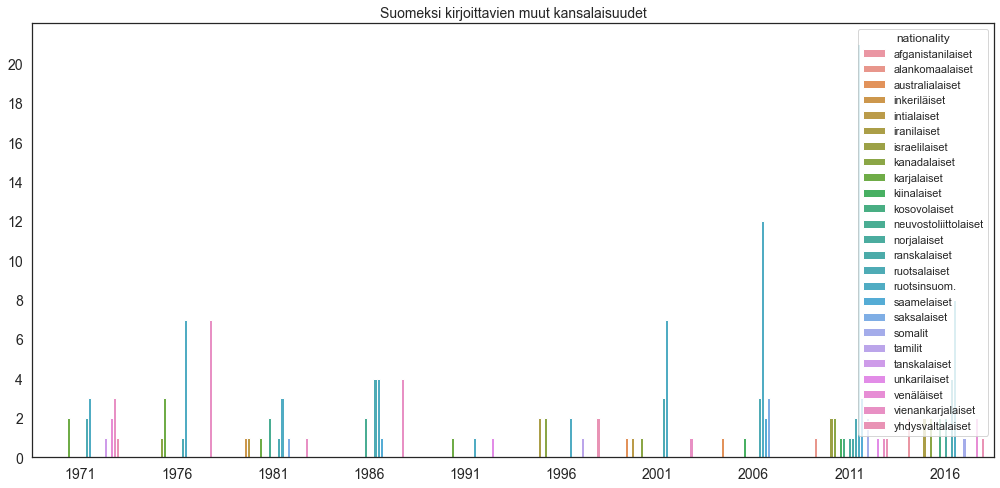

In [60]:
# barplot ?
fig, ax= plt.subplots(1,1,figsize=(14,7))


plt.rcParams["ytick.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["axes.labelsize"]=12

x= df3["period"].unique()


# suomeksi kirjoittavien kansalaisuudet 

axbar=sns.barplot(y="novel",x="period",#hue="lang", 
                      #jitter=True,
                      data=dfplot[dfplot["nationality"]!="suomalaiset"].sort_values(by="nationality"), hue="nationality",
                    
                   ax=ax,
                     #palette=colormap_new
                     )




#,  color=sns.color_palette("prism"))
#ax[1]=sns.scatterplot(y=y2_fi,x=x,marker="o", ax=ax[1], label="authors_fi", color=sns.color_palette("Blues")[4])
#ax[1]=sns.scatterplot(y=y1_fi,x=x, ax=ax[1], marker="*",s=70, label="novels_fi", color=sns.color_palette("Blues")[5])

axbar.set(xlabel='', ylabel='')
#ax[1].set(xlabel='', ylabel='')
#ax[2].set(xlabel='', ylabel='')

axbar.set_title('Suomeksi kirjoittavien muut kansalaisuudet', fontsize=14)
start=1970
end=2020
starty=0
endy=21
#axbar.xaxis.set_ticks(np.arange(start, end, 5))
axbar.yaxis.set_ticks(np.arange(starty, endy, 2))

fig.tight_layout()

In [ ]:
#
colormap_new["kiinalaiset"]=sns.color_palette("PuOr")[1]

In [ ]:
fig, ax= plt.subplots(1,1,figsize=(14,8))


plt.rcParams["ytick.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["axes.labelsize"]=12

x= df3["period"].unique()


# suomeksi kirjoittavien kansalaisuudet 

ax=sns.scatterplot(y="nationality",x="period",#hue="lang", 
                      #jitter=True,
                      data=dfplot[dfplot["nationality"]!="suomalaiset"].sort_values(by="nationality"), hue="nationality",
                      size="novel",sizes=(100, 300),alpha=0.7, 
                  # style=markers[:86],
                   ax=ax,
                     palette=colormap_new
                     )




#,  color=sns.color_palette("prism"))
#ax[1]=sns.scatterplot(y=y2_fi,x=x,marker="o", ax=ax[1], label="authors_fi", color=sns.color_palette("Blues")[4])
#ax[1]=sns.scatterplot(y=y1_fi,x=x, ax=ax[1], marker="*",s=70, label="novels_fi", color=sns.color_palette("Blues")[5])

ax.set(xlabel='', ylabel='')
#ax[1].set(xlabel='', ylabel='')
#ax[2].set(xlabel='', ylabel='')

#ax.set_title('Suomeksi kirjoittavien muut kansalaisuudet', fontsize=14)
#ax[1].set_title('Suomen kansalaisten muunkieliset kirjat', fontsize=18)
#ax[1].set_title('Suomeksi kirjoittavien ilmoittama kielitaito', fontsize=18)

#ax.legend([],[], frameon=False)
#ax[1].legend([],[], frameon=False)
#ax[1].legend([],[], frameon=False)
start=1970
end=2020
starty=0
endy=21
ax.xaxis.set_ticks(np.arange(start, end, 5))
#ax.yaxis.set_ticks(np.arange(starty, endy, 5))
#ax[1].xaxis.set_ticks(np.arange(start, end, 5))
#ax[1].xaxis.set_ticks(np.arange(start, end, 5))
#ax.set_yticklabels(labels=nationalitylabels#,rotation=20, ha='right', 
#                      )
#ax[1].yaxis.

#plt.rcParams['axes.titlesize'] = 16

lgd=ax.legend(handles=legends[-5:], labels=labels[-5:], loc='center', bbox_to_anchor=(0.5, 
                                               -0.07),
          ncol=6, fancybox=False, shadow=False,prop={'size': 12}) 


fig.tight_layout()
fig.savefig('../../output/suomeksi_kansallisuus.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [ ]:
legends, labels=ax.get_legend_handles_labels()

## Finnish authors in other languages

In [ ]:
# finnish authors writing in other languages
df2b=df_fo[df_fo["nat"].str.contains("/p35259")]

df2b
finns=df2b[(df2b["year"]>1999) & (~df2b["lang"].isin(["http://lexvo.org/id/iso639-3/swe","http://www.yso.fi/onto/koko/p2682"]))]
print(finns["author"].nunique())
finns.groupby("lang")["author"].nunique()

In [ ]:
# saamelaiset
sami=df2b[(df2b["lang"].isin(["http://lexvo.org/id/iso639-5/smi","http://lexvo.org/id/iso639-3/sme"]))]
print(sami["author"].nunique())
sami["author"].nunique()

In [ ]:
df_fo["nat"]
nat_labels

In [ ]:
# sami translations
foreigns_2.groupby(["nat","nationality"])["author"].nunique()
sami2=df_fo[df_fo["nat"].isin(["http://www.yso.fi/onto/koko/p32570","http://www.yso.fi/onto/koko/p64245","http://www.yso.fi/onto/koko/p72640","http://www.yso.fi/onto/yso/p11537","http://www.yso.fi/onto/kauno/p1830"])]
sami2["author"].nunique()